In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


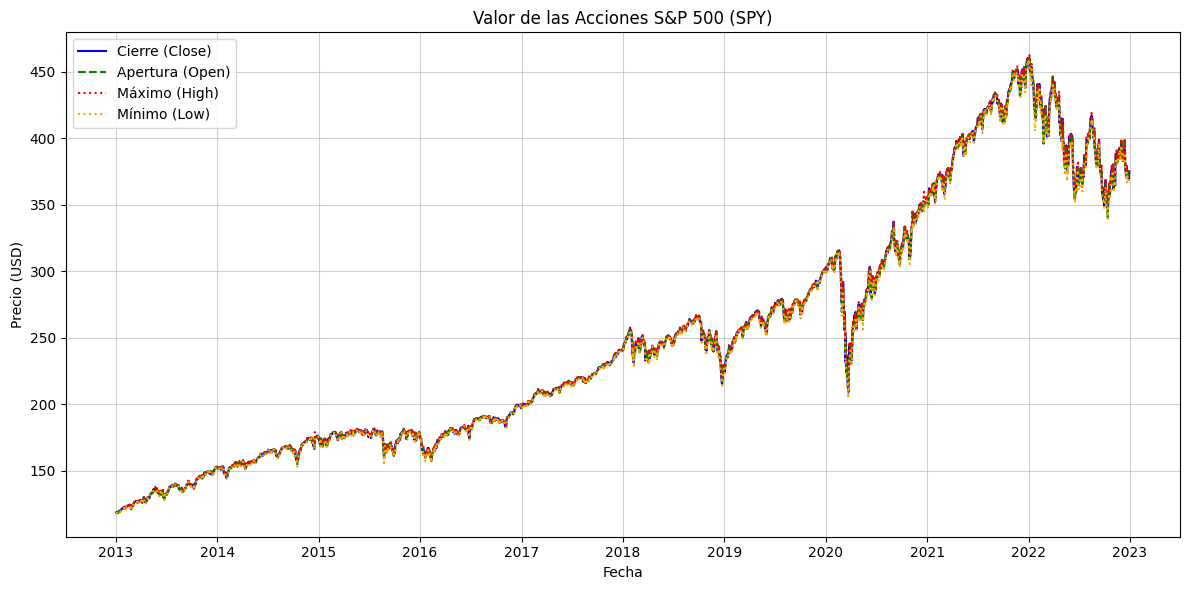

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



df = pd.read_csv('spy.csv',parse_dates=['Date'], date_format='%d/%m/%y', index_col='Date')

# Sub Intervalo elegido 2013 a 2023 ambos enero.
df_sub = df.loc['2013-01-01':'2023-01-01']

# 2. Graficar la serie de tiempo
plt.figure(figsize=(12, 6))
# Curva 1: Precio de Cierre (Close) - Generalmente la más importante
plt.plot(df_sub.index, df_sub['Close'], label='Cierre (Close)', color='blue')

# Curva 2: Precio de Apertura (Open)
plt.plot(df_sub.index, df_sub['Open'], label='Apertura (Open)', color='green', linestyle='--')

# Curva 3: Precio Máximo (High)
plt.plot(df_sub.index, df_sub['High'], label='Máximo (High)', color='red', linestyle=':')

# Curva 4: Precio Mínimo (Low)
plt.plot(df_sub.index, df_sub['Low'], label='Mínimo (Low)', color='orange', linestyle=':')


plt.title('Valor de las Acciones S&P 500 (SPY)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    exp_val = -((data - mean)**2.) / (2 * sigma**2.)
    # fix de tipos:
    exp_val = exp_val.astype(np.float32)
    return np.exp( exp_val )

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self, muestra=True):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.muestra=muestra



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        if self.muestra:
            print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)
        
    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        if self.muestra:
            print("nivel_acti shape:", nivel_acti.shape)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        if self.muestra:
            print("sumMu shape:", sumMu.shape)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        # fix de tipos:
        A = A.astype(np.float32)
        b = b.astype(np.float32)

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        if self.muestra:
            print("solutions shape:", solutions.shape)
        #print(solutions)

        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()



--- 0.6633381843566895 seconds ---
nivel_acti shape: (2518, 17)
sumMu shape: (2518, 1)
solutions shape: (34,)

Modelo Sugeno entrenado con radii=0.19.
Número de reglas (R) obtenidas: 17


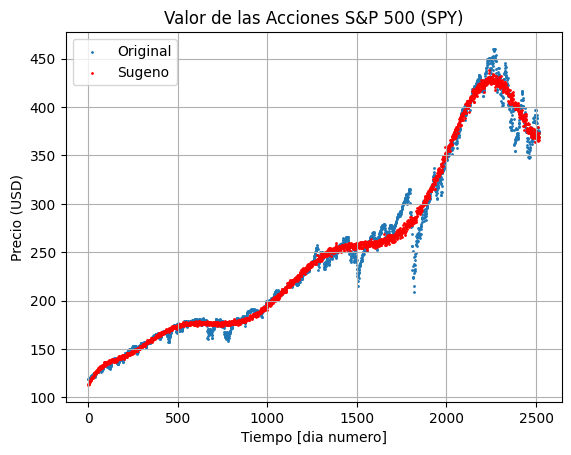

In [4]:


tiempo = np.arange(len(df_sub))
precio_cierre = df_sub['Close'].values
data_spy = np.vstack((tiempo, precio_cierre)).T

modelo_spy = fis()
radii_inicial = 0.19
modelo_spy.genfis(data_spy, radii=radii_inicial)


print(f"\nModelo Sugeno entrenado con radii={radii_inicial}.")
print(f"Número de reglas (R) obtenidas: {len(modelo_spy.rules)}")

# Paso 3: Evaluar el modelo
salida_modelo = modelo_spy.evalfis(data_spy[:, 0].reshape(-1, 1))  # Solo la variable de entrada

# Paso 4: Graficar
plt.figure()
plt.scatter(tiempo, precio_cierre, s=1, label="Original")
plt.scatter(tiempo, salida_modelo, s=1,color='red', label="Sugeno")
plt.title('Valor de las Acciones S&P 500 (SPY)')
plt.xlabel("Tiempo [dia numero]")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.show()

--- 0.6637167930603027 seconds ---
nivel_acti shape: (2518, 17)
sumMu shape: (2518, 1)
solutions shape: (34,)

Modelo Sugeno entrenado con radii=0.19.
Número de reglas (R) obtenidas: 17


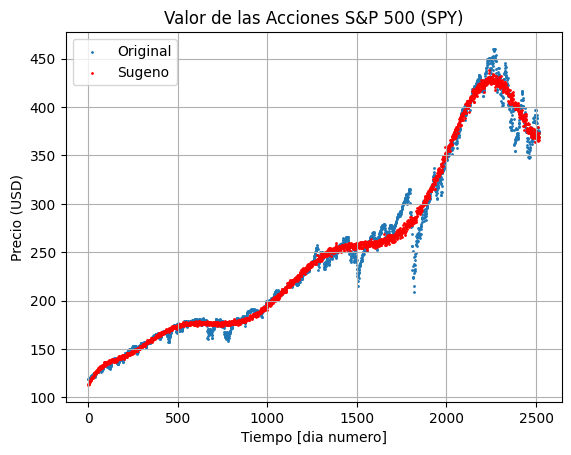

In [5]:
def calcular_mse(original, prediccion):
    """Calcula el Error Cuadrático Medio (MSE)."""
    return np.mean((original - prediccion)**2)

def entrenar_y_graficar_sugeno(df_datos, radii_inicial, mostrar_grafico=True):
    
    # Preparación de Datos (Input: Tiempo, Output: Precio Cierre)
    tiempo = np.arange(len(df_datos))
    precio_cierre = df_datos['Close'].values
    data_spy = np.vstack((tiempo, precio_cierre)).T

    # Entrenar el modelo
    modelo_spy = fis() 
    modelo_spy.genfis(data_spy, radii=radii_inicial)

    cant_clusters = len(modelo_spy.rules)
    
    # Evaluar el modelo
    salida_modelo = modelo_spy.evalfis(data_spy[:, 0].reshape(-1, 1))

    # Calcular MSE
    mse = calcular_mse(precio_cierre, salida_modelo)
    
    # Imprimir resultados y Graficar
    print(f"\nModelo Sugeno entrenado con radii={radii_inicial}.")
    print(f"Número de reglas (R) obtenidas: {len(modelo_spy.rules)}")
    
    if mostrar_grafico:
        plt.figure()
        plt.scatter(tiempo, precio_cierre, s=1, label="Original")
        plt.scatter(tiempo, salida_modelo, s=1,color='red', label="Sugeno")
        plt.title('Valor de las Acciones S&P 500 (SPY)')
        plt.xlabel("Tiempo [dia numero]")
        plt.ylabel("Precio (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()

entrenar_y_graficar_sugeno(df_sub, radii_inicial=0.19)

MSE= 88.47273075513182   CantCluster= 776    radii= 0.01
MSE= 103.25305156875   CantCluster= 346    radii= 0.02
MSE= 118.03544359845385   CantCluster= 197    radii= 0.03
MSE= 122.2488357379098   CantCluster= 134    radii= 0.04
MSE= 130.51361204158715   CantCluster= 102    radii= 0.05
MSE= 129.31821982525236   CantCluster= 75    radii= 0.060000000000000005
MSE= 136.0112379638718   CantCluster= 69    radii= 0.06999999999999999
MSE= 135.8431090961954   CantCluster= 53    radii= 0.08
MSE= 135.09937372975438   CantCluster= 46    radii= 0.09
MSE= 140.32702548331122   CantCluster= 38    radii= 0.09999999999999999
MSE= 129.52951635034208   CantCluster= 33    radii= 0.11
MSE= 130.6881515682894   CantCluster= 29    radii= 0.12
MSE= 136.13857632367925   CantCluster= 27    radii= 0.13
MSE= 134.50972586846297   CantCluster= 23    radii= 0.14
MSE= 148.45032805381157   CantCluster= 22    radii= 0.15000000000000002
MSE= 140.55750014093732   CantCluster= 22    radii= 0.16
MSE= 145.56308905651176   Cant

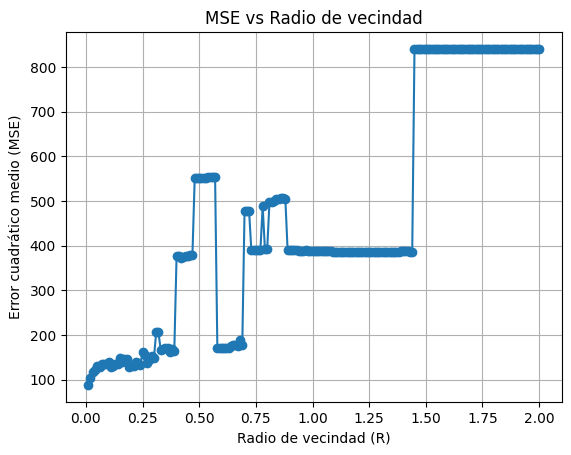

In [6]:
radii_values = np.linspace(0.01, 2.0, 200)  # por ejemplo, 20 valores entre 0.1 y 2.0
mse_values = []

for r in radii_values:
    modelo_spy = fis(muestra=False)
    modelo_spy.genfis(data_spy, radii=r)
    y_pred = modelo_spy.evalfis(data_spy[:, 0].reshape(-1,1))
    y_true = data_spy[:, 1]
    mse = np.mean((y_true - y_pred)**2)
    mse_values.append(mse)
    print("MSE=",mse,"  CantCluster=", len(modelo_spy.rules),"   radii=",r)

plt.figure()
plt.plot(radii_values, mse_values, marker='o')
plt.xlabel('Radio de vecindad (R)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('MSE vs Radio de vecindad')
plt.grid(True)
plt.show()

--- 1.0361406803131104 seconds ---
nivel_acti shape: (2518, 33)
sumMu shape: (2518, 1)
solutions shape: (66,)

Modelo Sugeno entrenado con radii=0.11.
Número de reglas (R) obtenidas: 33


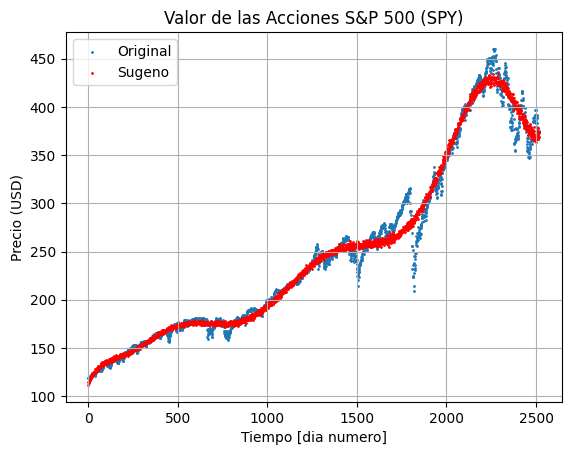

In [7]:
#Opción 1
#    MSE= 129.52951635034208   CantCluster= 33    radii= 0.11
entrenar_y_graficar_sugeno(df_sub, radii_inicial=0.11)

--- 0.650367259979248 seconds ---
nivel_acti shape: (2518, 17)
sumMu shape: (2518, 1)
solutions shape: (34,)

Modelo Sugeno entrenado con radii=0.19.
Número de reglas (R) obtenidas: 17


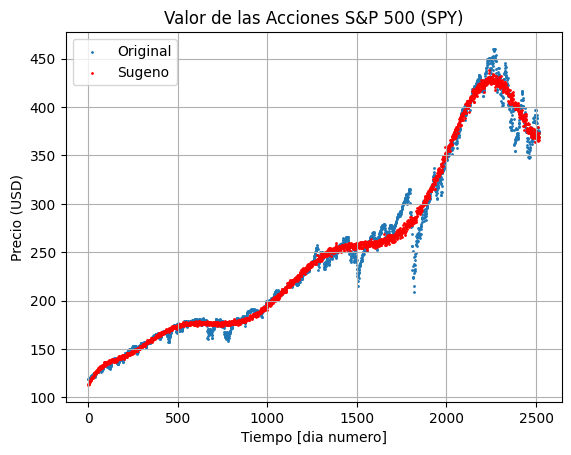

In [8]:
#Opción 2
#    MSE= 129.34979940509817   CantCluster= 17    radii= 0.19
entrenar_y_graficar_sugeno(df_sub, radii_inicial=0.19)

--- 1.3932907581329346 seconds ---
nivel_acti shape: (2518, 46)
sumMu shape: (2518, 1)
solutions shape: (92,)

Modelo Sugeno entrenado con radii=0.09.
Número de reglas (R) obtenidas: 46


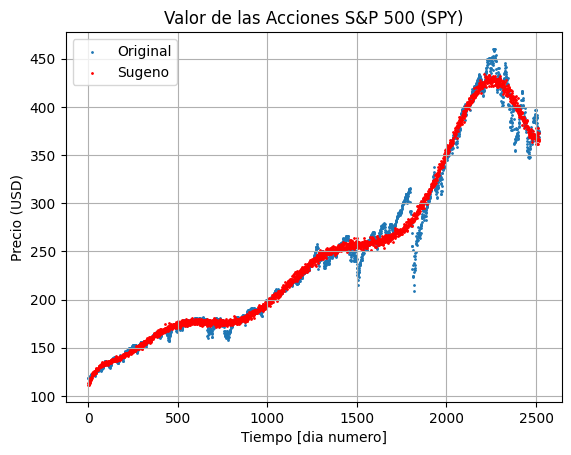

In [9]:
#Opción 3
#    MSE= 135.09937372975438   CantCluster= 46    radii= 0.09
entrenar_y_graficar_sugeno(df_sub, radii_inicial=0.09)

--- 0.43082642555236816 seconds ---
nivel_acti shape: (2518, 7)
sumMu shape: (2518, 1)
solutions shape: (14,)

Modelo Sugeno entrenado con radii=0.37.
Número de reglas (R) obtenidas: 7


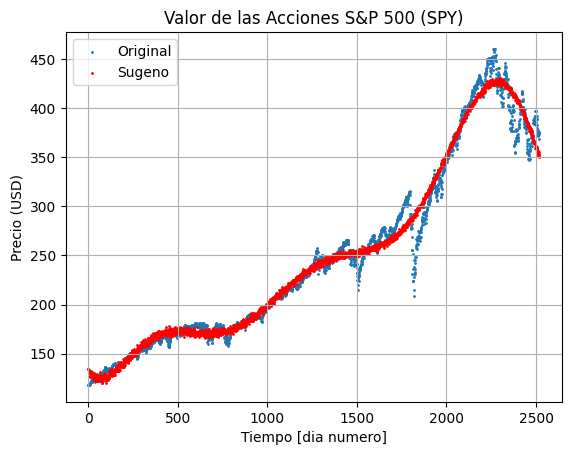

In [10]:
#Opción 4
#    MSE= 162.48158477515992   CantCluster= 7    radii= 0.37
entrenar_y_graficar_sugeno(df_sub, radii_inicial=0.37)